Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Instantiating visualizer


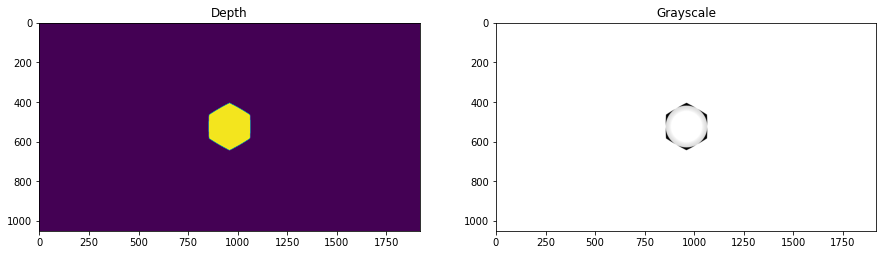

In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


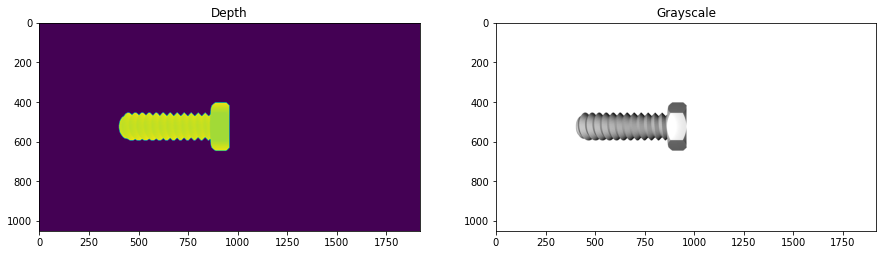

In [2]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=16.25, y=-30.39, z=4.68
x_rotate=-0.0°, y_rotate=-5.37°, z_rotate=12.04°


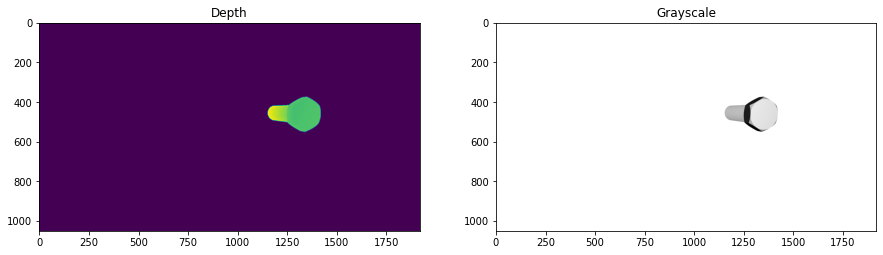

Now I'm a point cloud. Try moving me around!


In [3]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=False)

Truth
x=0.0, y=0.0, z=10.0
x_rotate=0.0°, y_rotate=20.0°, z_rotate=0.0°


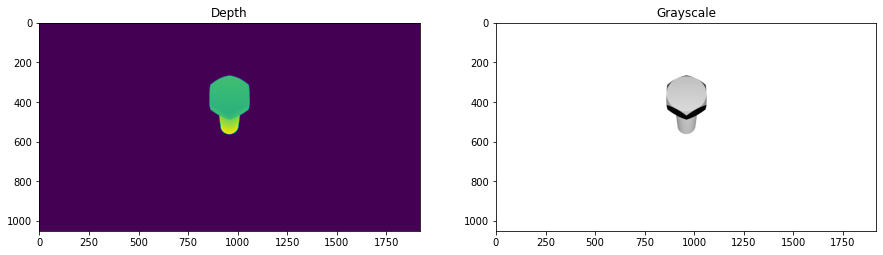

Estimate
x=4.03, y=-0.01, z=7.48
x_rotate=0.0°, y_rotate=0.0°, z_rotate=0.0°

Error: 8.392


In [4]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    trns_center = trns_pcd.get_center()
    translation = (trns_center - orig_center)
    rot = np.zeros(3) # dummy values
    rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
    rot = R.from_euler('xyz', rot).as_matrix()
    return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,0,10,0,20,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

In [5]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

6.393606008280279

In [6]:
import os
os.environ["DISCORD_USERNAME"] = "josiah"

In [7]:
from utility.pose_estimation import make_submission, test_images
from tqdm import tqdm

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|██████████| 200/200 [00:06<00:00, 29.76it/s]


Mean rmse=6.6153
Your ranking: #9

In [8]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

Your Ranking: #9
                       score
name                        
CapnCrunch        -14.555914
Catherine Duong    -6.615265
Haoshen           -14.555914
Josiah            -14.555914
Katherine_Stevens  -6.679010
Legolas           -14.555914
Seth Hamilton      -6.679010
THANOS            -14.555914
YoungBreezy       -14.555914
bhanu             -14.555914
conor              -6.612451
danbeltran         -6.622292
fardeenmozumder   -14.555914
josiah             -6.615265
marbhic            -6.679010
mashedpotatoes    -14.555914
nebula             -6.679010
stark              -6.617889

In [9]:
get_myscores(Challenge.POSE)

[-6.615264666694852,
 -6.615264666694852,
 -6.617888525878715,
 -6.617888525878715,
 -6.622291525556609,
 -6.632729496402323,
 -6.632729496402323,
 -6.679010431471446]

# Robot Control Challenge

In [10]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

   bolt position                            robot visited positions  time  \
0          9.251                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.02   
1         -7.879  [2.0, 4.0, 6.0, 8.0, 9.25079309271735, 9.25079...  0.04   
2         -4.324  [7.25079309271735, 5.25079309271735, 3.2507930...  0.06   
3          8.994  [-5.878811366833399, -4.323745667705058, -4.32...  0.08   
4         -7.141  [-2.323745667705058, -0.3237456677050581, 1.67...  0.10   
5        -10.083  [6.994447421982798, 4.994447421982798, 2.99444...  0.12   
6          5.894  [-9.140946563695014, -10.082988735080638, -10....  0.14   
7         -7.296  [-8.082988735080638, -6.082988735080638, -4.08...  0.16   
8        -16.865  [3.894437486278072, 1.894437486278072, -0.1055...  0.18   
9         -0.115  [-9.296346872352629, -11.296346872352629, -13....  0.20   

   rewards  
0    0.000  
1    0.000  
2    1.445  
3    0.000  
4    0.000  
5    2.058  
6    0.000  
7    0.000  
8    0.000  
9    0.000  
Total Rew

In [19]:
from utility.remote_env import RobotorqueEnvironment
from tqdm import tqdm 

env = RobotorqueEnvironment(Challenge.COMBINED)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [estimator(state['bolt_pose']).translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

   bolt position                            robot visited positions  time  \
0          9.403  [-0.006133388600342718, -0.006133388600342718,...  0.02   
1         -7.289  [1.9938666113996573, 3.9938666113996573, 5.993...  0.04   
2         -3.037  [7.2576622527693075, 5.2576622527693075, 3.257...  0.06   
3         11.328  [-5.2275507713285965, -3.2275507713285965, -3....  0.08   
4         -3.471  [-1.025487535100872, 0.9745124648991279, 2.974...  0.10   
5         -4.885  [9.126723944523627, 7.1267239445236275, 5.1267...  0.12   
6         13.011  [-4.869471684024911, -4.869471684024911, -4.86...  0.14   
7          2.077  [-2.8694716840249113, -0.8694716840249113, 1.1...  0.16   
8         -5.121  [10.723569666010153, 8.723569666010153, 6.7235...  0.18   
9         14.387  [0.055900094226130737, -1.9440999057738693, -3...  0.20   

   rewards  
0    0.000  
1    0.000  
2    0.810  
3    0.000  
4    0.000  
5    3.575  
6    0.000  
7    0.000  
8    0.000  
9    0.000  
Total Rew